# Import Dependencies

In [2]:
%pip install cdlib scikit-learn pandas plotly hvplot community python-louvain dynetx seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import networkx as nx
import dynetx as dn

from cdlib import algorithms, evaluation
import csv
import numpy as np
import pandas as pd
import os
import seaborn as sns

from sklearn.metrics import rand_score
from sklearn.metrics import adjusted_rand_score


from scipy.stats import spearmanr
from scipy.stats import kendalltau
from scipy.spatial import distance

from networkx.algorithms import approximation
from networkx.algorithms.community.quality import modularity
from networkx.algorithms.centrality import closeness_centrality

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

from sklearn.metrics import pair_confusion_matrix
import matplotlib.colors as mcolors
from matplotlib.patches import Patch

import colorsys
import random

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'wurlitzer', 'graph_tool', 'infomap', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'pyclustering', 'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


# Level 1 Network Formation

We experiment with varying levels of delta, from (0.15, 0.5, 0.85).

In [4]:
# Load the dataset
file_path = "../dataset/level_1/level_1.txt"
df = pd.read_csv(file_path, sep="\t")

level_2_df = pd.read_csv("../dataset/level_2/level_2.txt", sep="\t")

# Create a mapping of Gene to Level_2
gene_to_level_2 = dict(zip(level_2_df["Gene"], level_2_df["Level_2"]))

# Extract relevant columns
genes = df["Gene"]
level_1_classes = df["Level_1"]
expression_data = df.iloc[:, 2:].values  # Extract time-series expression data

# Compute Pearson correlation matrix
correlation_matrix = np.corrcoef(expression_data)

# Threshold for value-based graph construction
delta_values = np.arange(0.1, 1, 0.05)

# Initialize array to store results for each delta value
results = []

for delta in delta_values:
    threshold = delta
    adjacency_matrix = (correlation_matrix >= threshold ).astype(int)

    # Create a graph
    G = nx.Graph()

    # Add nodes with Level 1 classification as attributes
    for idx, gene in enumerate(genes):
        level_2_class = gene_to_level_2.get(gene, None) # Get Level_2 if it exists, otherwise None
        G.add_node(gene, level_1=level_1_classes[idx], level_2=level_2_class)

    # Add edges based on Pearson correlation threshold
    edges = []
    for i in range(len(genes)):
        for j in range(i + 1, len(genes)):
            if adjacency_matrix[i, j] == 1:
                pearson_coefficient = correlation_matrix[i, j]
                G.add_edge(genes[i], genes[j], weight=pearson_coefficient)

    # Remove singletons
    singletons = list(nx.isolates(G))
    G.remove_nodes_from(singletons)

    # Compute additional graph properties
    avg_degree = sum(dict(G.degree()).values()) / len(G.nodes())  # Average degree
    density = nx.density(G)  # Graph density
    avg_clustering = nx.average_clustering(G)  # Average clustering coefficient
    largest_cc = max(nx.connected_components(G), key=len)  # Largest connected component
    largest_cc_size = len(largest_cc)  # Size of the largest component
    diameter = nx.diameter(G.subgraph(largest_cc)) if nx.is_connected(G) else None  # Diameter

		# get density of largest connected component
    largest_cc_graph = G.subgraph(largest_cc)
    largest_cc_density = nx.density(largest_cc_graph) if len(largest_cc_graph.nodes()) > 0 else 0
    # print(f"Delta: {delta}, Largest CC Density: {largest_cc_density}")
    # Store results for the current delta, including the graph
    results.append({
        "Delta": delta,
        "Graph": G,  # Store the graph object
        "Number of Nodes": len(G.nodes()),
        "Number of Edges": G.number_of_edges(),
        "Transitivity": nx.transitivity(G) if len(G.nodes()) > 0 else 0,
        "Singletons Removed": len(singletons),
        "Average Degree": avg_degree,
        "Density of Largest CC": largest_cc_density,
        "Average Clustering Coefficient": avg_clustering,
        "Largest Component Size": largest_cc_size,
        "Diameter (if connected)": diameter
    })

# Convert results to a DataFrame for visualization (excluding the graph object)
graph_properties = pd.DataFrame([{k: v for k, v in result.items() if k != "Graph"} for result in results])

output_dir = "../results/level_1"
if not os.path.exists(output_dir):
	os.makedirs(output_dir)

# Save graph properties to a CSV file
graph_properties.to_csv(f"{output_dir}/graph_properties.csv", index=False)
graph_properties

,Delta,Number of Nodes,Number of Edges,Transitivity,Singletons Removed,Average Degree,Density of Largest CC,Average Clustering Coefficient,Largest Component Size,Diameter (if connected)
0,0.10,384,33695,0.760440,0,175.494792,0.458211,0.749597,384,3.0
1,0.15,384,31622,0.763279,0,164.697917,0.430021,0.750456,384,3.0
2,0.20,384,29611,0.766537,0,154.223958,0.402674,0.751598,384,3.0
3,0.25,384,27690,0.769617,0,144.218750,0.376550,0.751233,384,3.0
4,0.30,384,25760,0.775733,0,134.166667,0.350305,0.752632,384,3.0
5,0.35,384,23918,0.779619,0,124.572917,0.325256,0.751186,384,4.0
6,0.40,384,22069,0.784625,0,114.942708,0.300112,0.749807,384,4.0
7,0.45,384,20131,0.789246,0,104.848958,0.273757,0.745790,384,4.0
8,0.50,384,18217,0.789861,0,94.880208,0.247729,0.739437,384,5.0
9,0.55,383,16247,0.786742,1,84.840731,0.222096,0.726502,383,6.0


# Level 1 Network Visualization

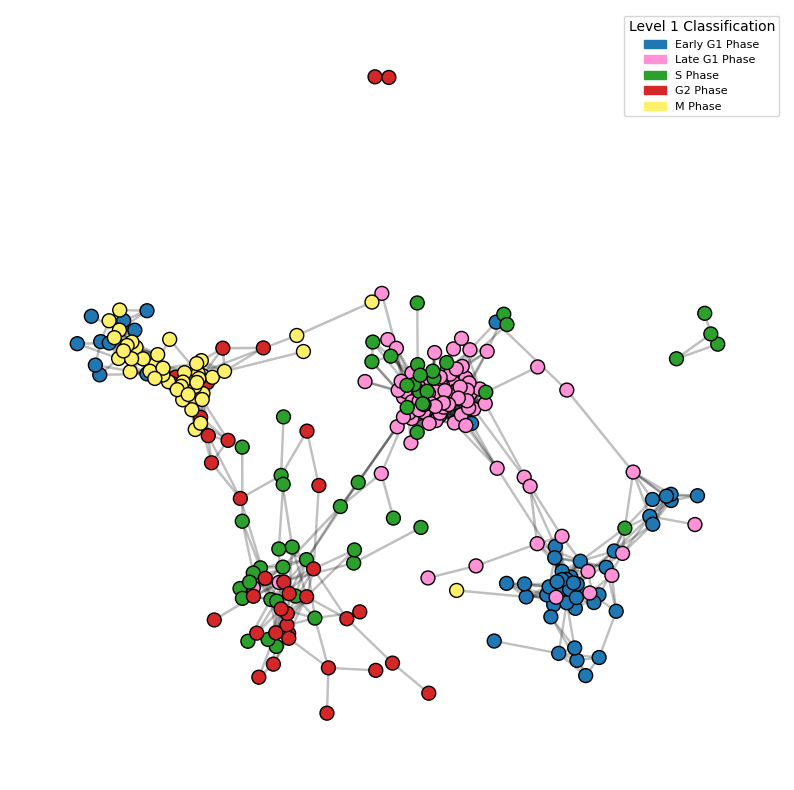

In [5]:
TABLEAU_COLORS = {
    'tab:blue': '#1f77b4',
    'tab:pink': '#ff91d7',
    'tab:green': '#2ca02c',
    'tab:red': '#d62728',
    'tab:yellow': '#fff06b',
}
# Define unique colors for each Level 1 classification
unique_classes = level_1_classes.unique()
color_map = {cls: TABLEAU_COLORS[list(TABLEAU_COLORS.keys())[i]] for i, cls in enumerate(unique_classes)}

# Use the graph with delta = 0.85
G = results[15]["Graph"]  # Choose the graph with delta = 0.85

# Assign colors to nodes based on Level 1 classification
node_colors = [color_map[G.nodes[n]["level_1"]] for n in G.nodes()]

# Edge weights for visualization (stronger edges appear tighter)
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Generate graph layout
plt.figure(figsize=(10, 10))
cell_cycle_phases = ["Early G1 Phase", "Late G1 Phase", "S Phase", "G2 Phase", "M Phase"]
legend_handles = [Patch(color=color, label=f'{cell_cycle_phases[cls-1]}') for cls, color in color_map.items()]
plt.legend(handles=legend_handles, loc="best", fontsize=8, title="Level 1 Classification")
pos = nx.spring_layout(G, weight='weight', k=0.1, seed=10)  # Spring layout based on weights

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100, alpha=1, edgecolors="black")

# Draw edges with thickness based on weight
nx.draw_networkx_edges(G, pos, alpha=0.25, edge_color="black", width=[w * 2 for w in edge_weights])

# Show plot
# plt.title(f"Cho Gene Co-Expression Network (Value-Based, δ = {delta})")
plt.axis("off")
# plt.savefig("../results/level_1/visualization/level1_gcn_L1.png", dpi=300)
plt.show()

# Level 2 Network Visualization
For this section, nodes/genes in the dataset that do not have a Level 2 classification will be colored gray.

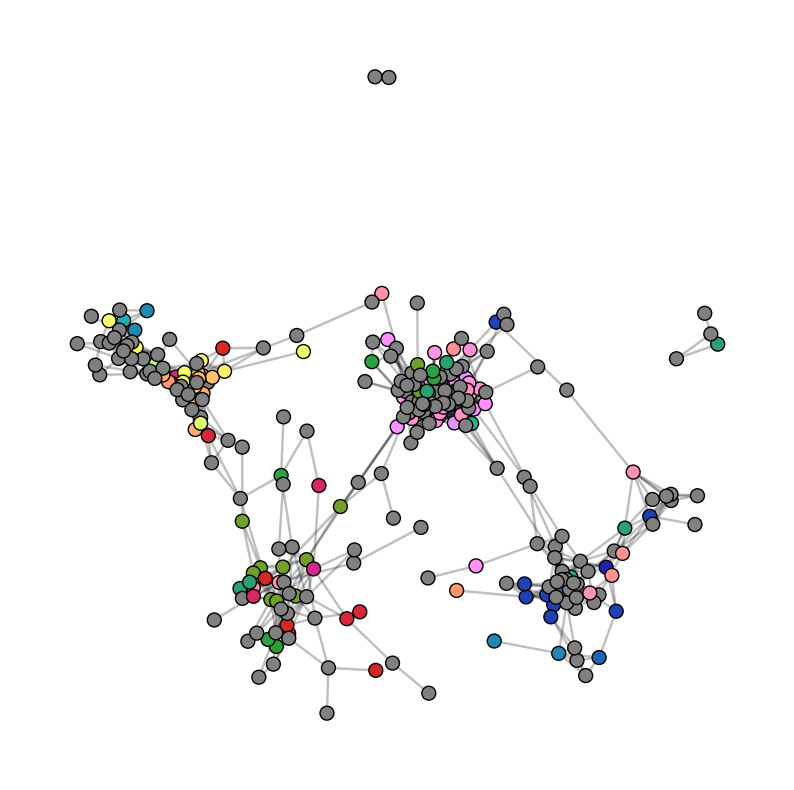

In [6]:
base_colors = {cls: TABLEAU_COLORS[list(TABLEAU_COLORS.keys())[i]]
               for i, cls in enumerate(unique_classes)}

# Function to generate distinct but related colors for Level 2 classifications
def generate_hue_variations(base_color, num_shades):
    """Generate distinct hues within a color family using HSL space."""
    base_rgb = mcolors.to_rgb(base_color)
    base_hls = colorsys.rgb_to_hls(*base_rgb)
    
    # Create variations by adjusting only the HUE component
    hues = np.linspace(base_hls[0] - 0.1, base_hls[0] + 0.1, num_shades)
    hues = np.clip(hues, 0, 1)  # Ensure hues are within valid range
    
    return [mcolors.to_hex(colorsys.hls_to_rgb(hue, base_hls[1], base_hls[2])) for hue in hues]

# Generate Level 2 colors based on hue variations within the Level 1 color family
level_2_groups = level_2_df.groupby("Level_1")["Level_2"].unique()
level_2_colors = {}

for lvl1, lvl2_values in level_2_groups.items():
    shades = generate_hue_variations(base_colors[lvl1], len(lvl2_values))
    for idx, lvl2 in enumerate(lvl2_values):
        level_2_colors[lvl2] = shades[idx]

# Assign colors to nodes based on Level 2 classification
node_colors_level_2 = [level_2_colors[G.nodes[n]["level_2"]] if G.nodes[n]["level_2"] in level_2_colors else "#808080" # Gray color
                       for n in G.nodes()]

# Edge weights for visualization
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]

# Generate graph layout
plt.figure(figsize=(10, 10))
cell_cycle_phases = ["Early G1 Phase", "Late G1 Phase", "S Phase", "G2 Phase", "M Phase"]
legend_handles_lvl2 = [Patch(color=color, label=f'Level 2: {cls}') for cls, color in level_2_colors.items()]
# plt.legend(handles=legend_handles_lvl2, loc="best", fontsize=6, title="Classification Hierarchy")

pos = nx.spring_layout(G, weight='weight', k=0.1, seed=10)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_colors_level_2, node_size=100, alpha=1, edgecolors="black")

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.25, edge_color="black", width=[w * 2 for w in edge_weights])

# Show plot
# plt.title(f"Cho Gene Co-Expression Network (Value-Based, δ = {delta})")
plt.axis("off")
plt.savefig("../results/level_1/visualization/level1_gcn_L2.png", dpi=300)
plt.show()


# Community Detection Auxiliary Functions

These are the functions used during the Community Detection of our constructed network.

In [7]:
def visualize_disconnected_communities(G, communities, color_map, title="Paris Algorithm Communities"):
    """
    Visualizes detected communities as separate disconnected subgraphs while keeping Level 1 colors.

    Parameters:
    - G: NetworkX graph
    - communities: CDLib NodeClustering object (Paris, Infomap, Louvain, etc.)
    - color_map: Dictionary mapping Level 1 categories to colors
    - title: Title for the plot
    """

    # Define layout positioning for separate communities
    num_communities = len(communities.communities)
    fig, ax = plt.subplots(figsize=(12, 8))

    # Generate separate layouts for each community
    layouts = []
    for i in range(num_communities):
        layouts.append(nx.spring_layout(G.subgraph(communities.communities[i]), seed=42))

    # Normalize layout positions to avoid overlap
    spacing = 3
    for i, layout in enumerate(layouts):
        for node in layout:
            layout[node] += [i * spacing, 0]  # Shift positions to separate communities

    # Draw each community separately
    for i, community in enumerate(communities.communities):
        valid_nodes = [node for node in community if node in G]
        if not valid_nodes:
            continue  # Skip empty communities
        subG = G.subgraph(valid_nodes)
        pos = layouts[i]

        # Assign Level 1 colors
        node_colors = [color_map[G.nodes[n]["level_1"]] for n in subG.nodes()]

        # Draw nodes
        nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=200, alpha=1, edgecolors="black")

        # Draw edges
        nx.draw_networkx_edges(subG, pos, alpha=0.3, edge_color="black")

    # Create a legend for Level 1 classification
    cell_cycle_phases = ["Early G1 Phase", "Late G1 Phase", "S Phase", "G2 Phase", "M Phase"]
    legend_handles = [Patch(color=color, label=f'{cell_cycle_phases[cls-1]}') for cls, color in color_map.items()]
    plt.legend(handles=legend_handles, loc="best", fontsize=8, title="Level 1 Classification")

    # Display
    plt.title(title)
    plt.axis("off")
    plt.show()


In [8]:
import itertools

def modified_rand_score(labels_true, labels_pred, nodes_true_list, nodes_pred_list):
    """
    Compute the Modified Rand Index (MRI), an extension of the Rand Index
    that accounts for missing elements between partitions.

    Parameters
    ----------
    labels_true : list
        True labels corresponding to the nodes.
    labels_pred : list
        Predicted labels corresponding to the nodes.
    nodes_true_list : list
        An ordered list of nodes corresponding to labels_true.
    nodes_pred_list : list
        An ordered list of nodes corresponding to labels_pred.

    Returns
    -------
    mri : float
        The Modified Rand Index score.
    """

    n = len(labels_true)
    total_pairs = n * (n - 1) // 2  # All possible unique node pairs
    n_00, n_11, n_xx = 0, 0, 0  # Initialize counts

    # Convert lists to sets for fast lookup
    nodes_true_set = set(nodes_true_list)
    nodes_pred_set = set(nodes_pred_list)

    # Identify common nodes between the two partitions
    common_nodes = nodes_true_set.intersection(nodes_pred_set)

    # Iterate over all node pairs
    for i, j in itertools.combinations(range(n), 2):  # Iterate over all unique pairs
        node_i, node_j = nodes_true_list[i], nodes_true_list[j]

        # If either node is missing from the common set, count this pair as n_xx.
        if node_i not in common_nodes or node_j not in common_nodes:
            n_xx += 1
        else:
            same_true = (labels_true[i] == labels_true[j])
            same_pred = (labels_pred[i] == labels_pred[j])
            if same_true and same_pred:
                n_11 += 1  # Agreeing pair (same in both)
            elif not same_true and not same_pred:
                n_00 += 1  # Agreeing pair (different in both)

    # Compute MRI Score
    if total_pairs == 0:
        return 1.0  # Perfect match in trivial cases

    MRI = (n_00 + n_11 + n_xx) / total_pairs
    return MRI


In [9]:
def evaluate_community(G_subgraph, communities):
	num_communities = len(communities.communities)
	largest_community_size = max(len(c) for c in communities.communities)
	community_sizes = [len(c) for c in communities.communities]
	num_singletons = sum(1 for c in communities.communities if len(c) == 1)
	modularity_score = evaluation.newman_girvan_modularity(G_subgraph, communities).score

	community_centralities = []
	for community in communities.communities:
		if len(community) > 1:
			subgraph = G_subgraph.subgraph(community)
			centralities = nx.closeness_centrality(subgraph).values()
			community_centralities.extend(centralities)
	avg_closeness_centrality = np.mean(community_centralities) if community_centralities else 0.0

	predicted_labels_dict = {node: -1 for node in G_subgraph.nodes()}
	for i, community in enumerate(communities.communities):
		for node in community:
			predicted_labels_dict[node] = i
	predicted_labels = [predicted_labels_dict[node] for node in G_subgraph.nodes()]

	true_labels_level_1 = [G_subgraph.nodes[n]["level_1"] for n in G_subgraph.nodes()]
	
	# ARI/RI/MRI
	ari_score = adjusted_rand_score(true_labels_level_1, predicted_labels)
	ri_score = rand_score(true_labels_level_1, predicted_labels)
	nodes_true_list = list(G_subgraph.nodes())
	nodes_pred_list = [node for community in communities.communities for node in community]
	mri_score = modified_rand_score(true_labels_level_1, predicted_labels, nodes_true_list, nodes_pred_list)

	return pd.DataFrame({
			"Number of Communities": [num_communities],
			"Nodes in Largest Community": [largest_community_size],
			"Community Sizes": [community_sizes],
			"Singletons": [num_singletons],
			"Modularity": [modularity_score],
			"Closeness Centrality": [avg_closeness_centrality],
			"ARI (Level 1)": [ari_score],
			"RI (Level 1)": [ri_score],
			"MRI (Level 1)": [mri_score],
			"Communities": [communities.communities]
	})

# Obtaining the Largest Connected Component in G of $\delta$ = 0.85

In [10]:
largest_cc_nodes = max(nx.connected_components(G), key=len)
G_lcc = G.subgraph(largest_cc_nodes).copy()

# Hierarchical Community Detection


## Paris Algorithm

In [12]:
paris_communities = algorithms.paris(G)
largest_paris_community_nodes = max(paris_communities.communities, key=len)
G_largest_paris = G.subgraph(largest_paris_community_nodes).copy()

# Apply Paris algorithm to the largest community
paris_communities_largest = algorithms.paris(G_largest_paris)
# Ensure that paris_communities_largest contains valid communities
if paris_communities_largest.communities:
	Paris_results = evaluate_community(G, paris_communities_largest)
else:
	print("Error: No communities found in paris_communities_largest.")
	Paris_results = None
# output_dir = "Paris - Graphs"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
# Paris_results.to_csv(f"{output_dir}/Paris_Results_Cho.csv")
Paris_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,3,130,"[130, 121, 59]",0,0.378579,0.357415,0.446067,0.7653,0.770725,"[[201, 228, 79, 224, 171, 136, 135, 164, 102, ..."


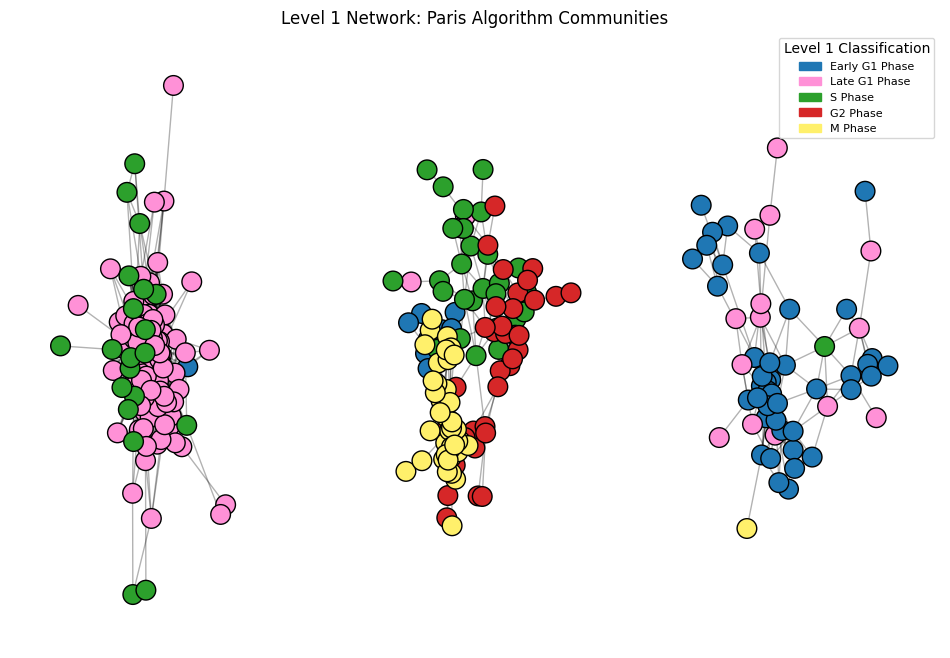

In [14]:
visualize_disconnected_communities(G, paris_communities_largest, color_map, title="Level 1 Network: Paris Algorithm Communities")

## LFM Algorithm

In [15]:
random.seed(42)
np.random.seed(42)

alpha_values = np.arange(0.1, 1.0, 0.1)
lfm_results_list = []
lfm_communities = []
for alpha in alpha_values:
	alpha_community = algorithms.lfm(G, alpha=alpha)
	lfm_communities.append(alpha_community)

	lfm_results = evaluate_community(G, alpha_community)
	lfm_results.insert(0, "Alpha", alpha)
	lfm_results_list.append(lfm_results)

# Combine all results into a single DataFrame
LFM_results = pd.concat(lfm_results_list, ignore_index=True)
LFM_results


,Alpha,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,0.1,3,310,"[310, 4, 2]",0,0.003495,0.158377,0.010951,0.274302,0.274302,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
1,0.2,3,310,"[310, 4, 2]",0,0.003495,0.158377,0.010951,0.274302,0.274302,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
2,0.3,4,310,"[310, 60, 4, 2]",0,0.145624,0.186919,0.114070,0.484911,0.484911,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
3,0.4,4,310,"[310, 60, 4, 2]",0,0.145624,0.186919,0.114070,0.484911,0.484911,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13..."
4,0.5,5,136,"[136, 121, 59, 4, 2]",0,0.380327,0.359964,0.446340,0.765461,0.765461,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
5,0.6,8,136,"[136, 66, 56, 52, 7, 4, 3, 2]",0,0.388131,0.436107,0.545822,0.826803,0.826803,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
6,0.7,9,135,"[135, 66, 54, 42, 14, 7, 4, 3, 2]",0,0.387929,0.458435,0.552915,0.832268,0.832268,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
7,0.8,12,135,"[135, 66, 54, 42, 32, 26, 7, 4, 3, 2, 2, 2]",0,0.371493,0.447544,0.542812,0.831264,0.831264,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
8,0.9,23,132,"[132, 48, 38, 32, 22, 18, 17, 11, 9, 9, 7, 4, ...",0,0.362229,0.524326,0.520522,0.831163,0.831163,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."


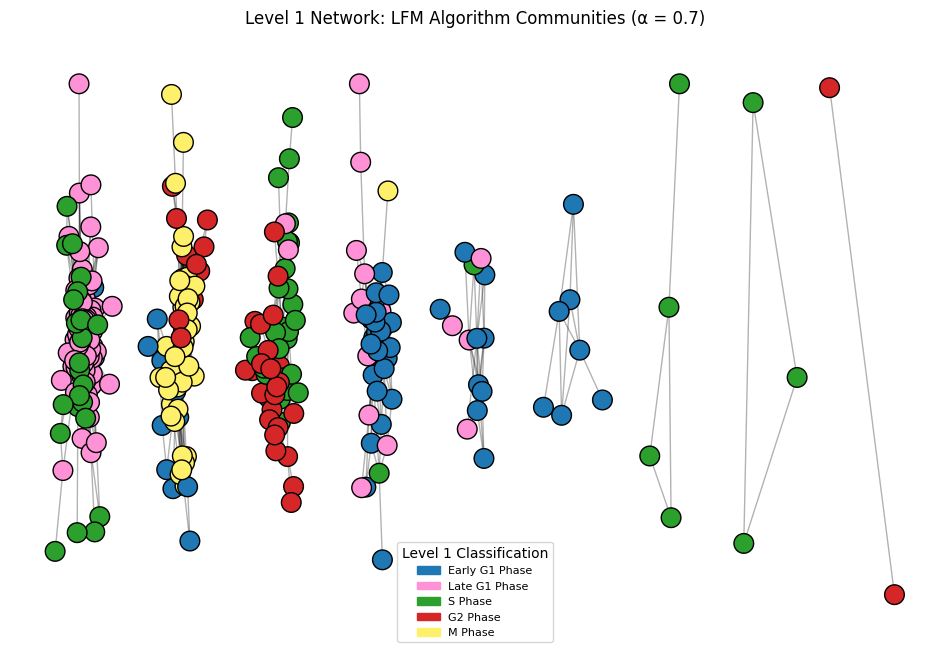

In [16]:
# Visualize the best performing LFM alpha value (alpha = 0.7)
best_lfm_communities = lfm_communities[6]
visualize_disconnected_communities(G, best_lfm_communities, color_map, title=f"Level 1 Network: LFM Algorithm Communities (α = {0.7})")

## Girvan Newman Algorithm

In [17]:
gn_levels = range(1, 11)
gn_results_list = []
gn_communities_list = []

for level in gn_levels:
	gn_level = level
	curr_community = algorithms.girvan_newman(G, level=gn_level)
	gn_communities_list.append(curr_community)

	gn_results = evaluate_community(G, curr_community)
	gn_results.insert(0, "GN Level", gn_level)

	gn_results_list.append(gn_results)

# Combine all results into a single DataFrame
GN_results = pd.concat(gn_results_list, ignore_index=True)
GN_results


,GN Level,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,1,4,240,"[240, 70, 4, 2]",0,0.205153,0.260453,0.249084,0.577135,0.577135,"[[0, 1, 2, 4, 6, 8, 9, 10, 11, 12, 13, 14, 15,..."
1,2,5,181,"[181, 70, 59, 4, 2]",0,0.329101,0.323853,0.392971,0.723990,0.723990,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
2,3,6,131,"[131, 70, 59, 50, 4, 2]",0,0.387429,0.424604,0.542276,0.822323,0.822323,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
3,4,7,131,"[131, 65, 59, 50, 5, 4, 2]",0,0.387238,0.437039,0.552498,0.827768,0.827768,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
4,5,8,131,"[131, 65, 50, 45, 14, 5, 4, 2]",0,0.386458,0.455586,0.541642,0.826522,0.826522,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
5,6,9,131,"[131, 65, 50, 38, 14, 7, 5, 4, 2]",0,0.386036,0.468077,0.532359,0.824272,0.824272,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
6,7,10,130,"[130, 65, 50, 38, 14, 7, 5, 4, 2, 1]",1,0.385958,0.469950,0.526203,0.822584,0.822584,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
7,8,11,129,"[129, 65, 50, 38, 14, 7, 5, 4, 2, 1, 1]",2,0.385878,0.470886,0.520071,0.820916,0.820916,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
8,9,12,128,"[128, 65, 50, 38, 14, 7, 5, 4, 2, 1, 1, 1]",3,0.385800,0.472439,0.523148,0.822684,0.822684,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."
9,10,13,127,"[127, 65, 50, 38, 14, 7, 5, 4, 2, 1, 1, 1, 1]",4,0.385721,0.474265,0.516988,0.821017,0.821017,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."


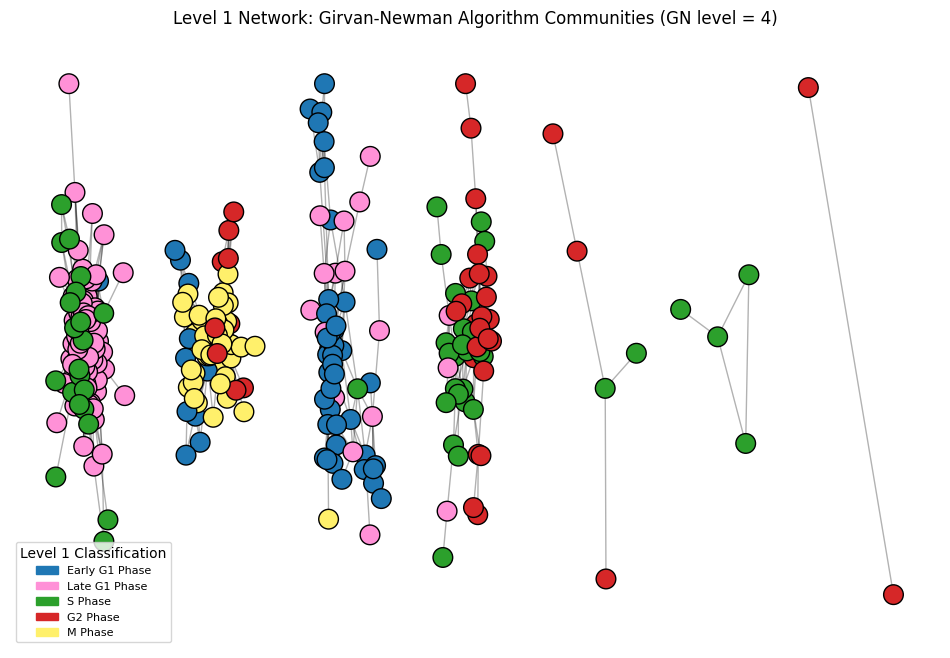

In [18]:
best_gn_community = gn_communities_list[3]  # Choose the graph with level = 4
visualize_disconnected_communities(G, best_gn_community, color_map, title=f"Level 1 Network: Girvan-Newman Algorithm Communities (GN level = 4)")

# Dynamic Community Detection
Using our formed network, we employ the Infomap and TILES algorithms.

## Infomap Algorithm

In [19]:
infomap_communities = algorithms.infomap(G)

Infomap_results = evaluate_community(G, infomap_communities)
Infomap_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,26,122,"[122, 38, 29, 24, 12, 10, 9, 9, 8, 7, 5, 5, 4,...",0,0.369617,0.607762,0.514523,0.835302,0.835302,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."


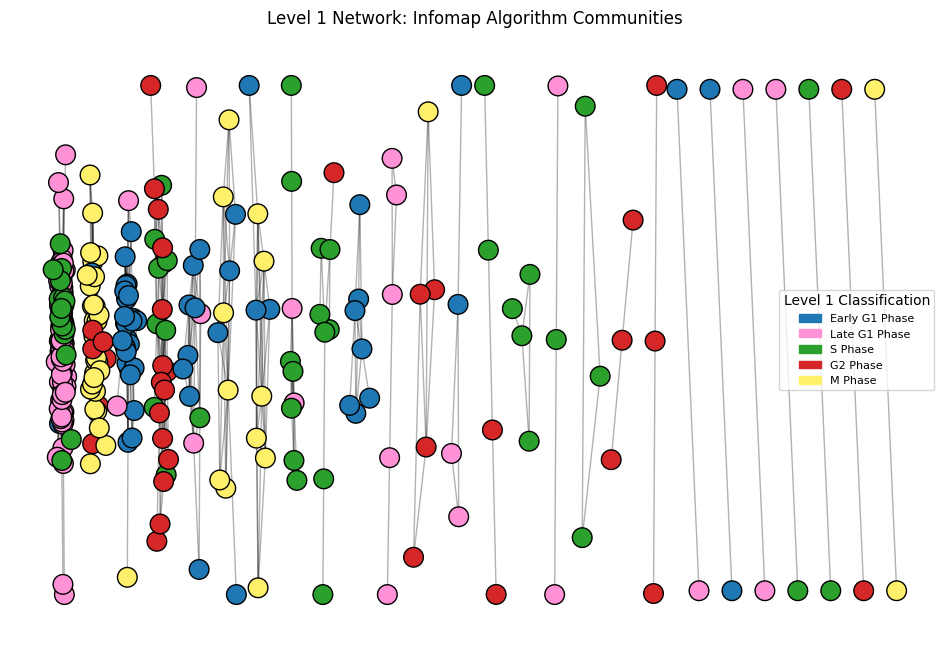

In [20]:
visualize_disconnected_communities(G, infomap_communities, color_map, title="Level 1 Network: Infomap Algorithm Communities")

## Walktrap Algorithm

In [21]:
walktrap_communities = algorithms.walktrap(G)

Walktrap_results = evaluate_community(G, walktrap_communities)
Walktrap_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,15,132,"[132, 64, 42, 36, 12, 7, 4, 4, 3, 2, 2, 2, 2, ...",0,0.384224,0.504135,0.533147,0.826422,0.826422,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64..."


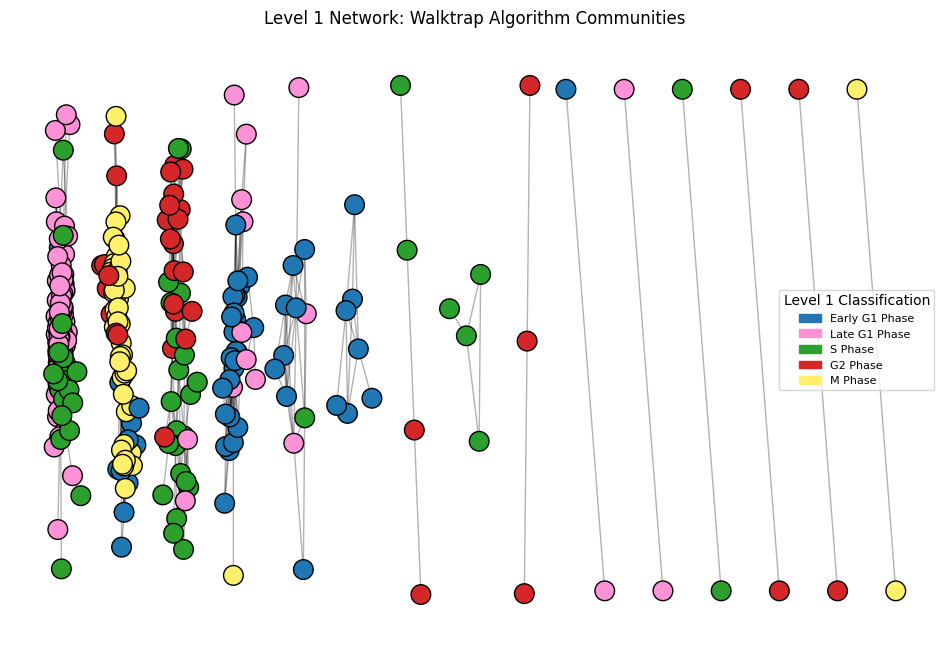

In [22]:
visualize_disconnected_communities(G, walktrap_communities, color_map, title="Level 1 Network: Walktrap Algorithm Communities")

## Spinglass Algorithm

In [32]:
spinglass_communities = algorithms.spinglass(G_lcc)

Spinglass_results = evaluate_community(G_lcc, spinglass_communities)
Spinglass_results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities
0,7,67,"[67, 65, 62, 57, 52, 6, 1]",1,0.451706,0.460406,0.379738,0.785364,0.785364,"[[YML109w, YGR109c, YPR120c, YNL289w, YPL256c,..."


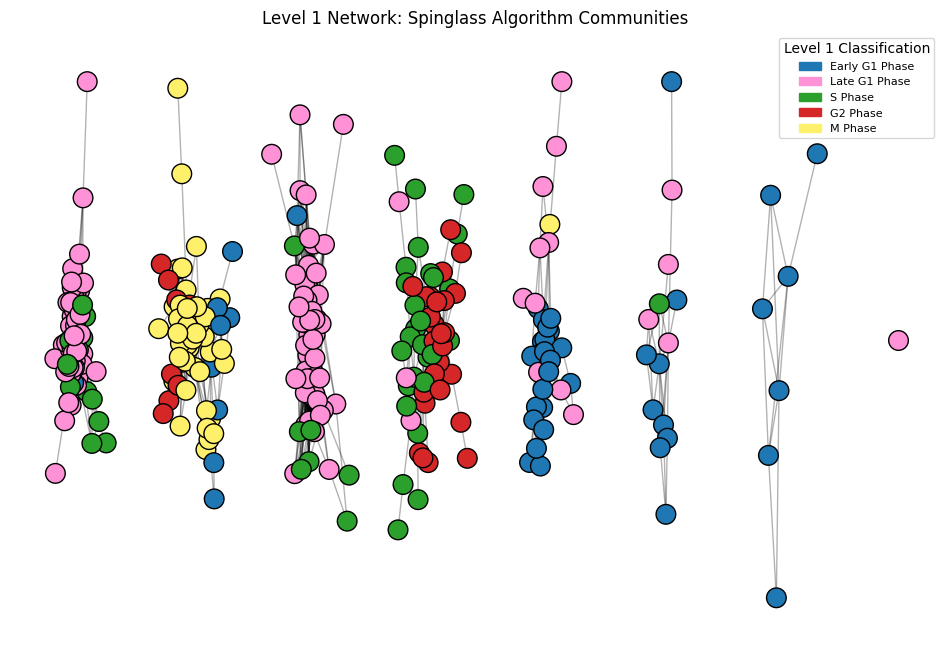

In [31]:
visualize_disconnected_communities(G_lcc, spinglass_communities, color_map, title="Level 1 Network: Spinglass Algorithm Communities")

# Community Detection Results

In [25]:
Community_Detection_Results = pd.concat([Paris_results, LFM_results.iloc[[6]], GN_results.iloc[[3]], Infomap_results, Walktrap_results, Spinglass_results], axis=0)
Community_Detection_Results.index = ["Paris", "LFM", "Girvan-Newman", "Infomap", "Walktrap",  "Spinglass"]

output_dir = "../results/level_1/community_detection_results"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
Community_Detection_Results.to_csv(f"{output_dir}/level1_cd_results.csv")

Community_Detection_Results

,Number of Communities,Nodes in Largest Community,Community Sizes,Singletons,Modularity,Closeness Centrality,ARI (Level 1),RI (Level 1),MRI (Level 1),Communities,Alpha,GN Level
Paris,3,130,"[130, 121, 59]",0,0.378579,0.357415,0.446067,0.765300,0.770725,"[[201, 228, 79, 224, 171, 136, 135, 164, 102, ...",NaN,NaN
LFM,9,135,"[135, 66, 54, 42, 14, 7, 4, 3, 2]",0,0.387929,0.458435,0.552915,0.832268,0.832268,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64...",0.7,NaN
Girvan-Newman,7,131,"[131, 65, 59, 50, 5, 4, 2]",0,0.387238,0.437039,0.552498,0.827768,0.827768,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64...",NaN,4.0
Infomap,26,122,"[122, 38, 29, 24, 12, 10, 9, 9, 8, 7, 5, 5, 4,...",0,0.369617,0.607762,0.514523,0.835302,0.835302,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64...",NaN,NaN
Walktrap,15,132,"[132, 64, 42, 36, 12, 7, 4, 4, 3, 2, 2, 2, 2, ...",0,0.384224,0.504135,0.533147,0.826422,0.826422,"[[2, 9, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64...",NaN,NaN
Spinglass,7,65,"[65, 64, 62, 56, 45, 14, 4]",0,0.451284,0.474120,0.386676,0.790980,0.790980,"[[YBR200w, YBR202w, YEL032w, YPL058c, YGR035c,...",NaN,NaN


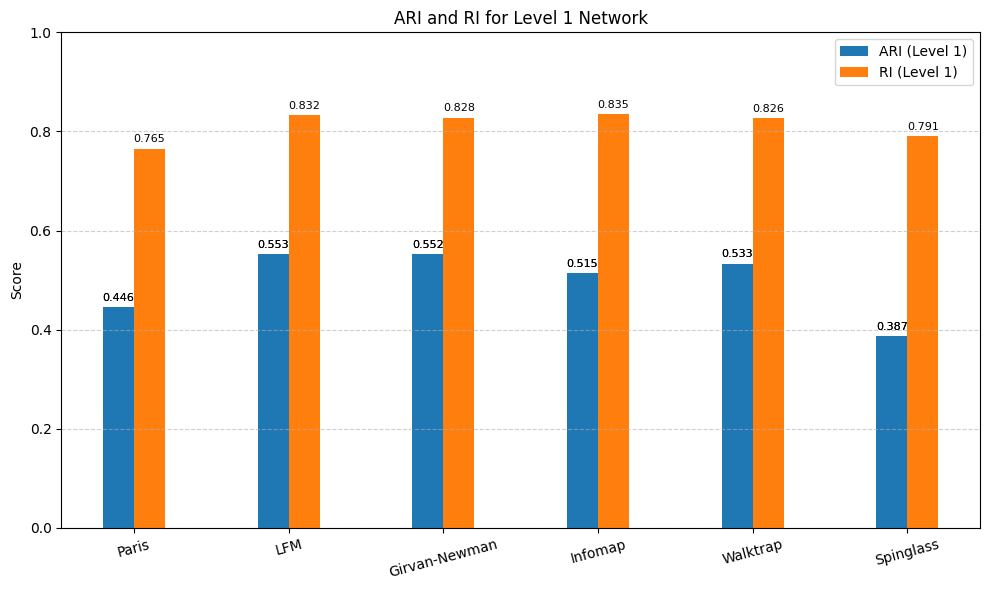

In [52]:
# Set labels and values
labels = Community_Detection_Results.index
x = np.arange(len(labels))
width = 0.2

metrics = ["ARI (Level 1)", "RI (Level 1)",]
offsets = [-0.5, 0.5]

fig, ax = plt.subplots(figsize=(10, 6))
for metric, offset in zip(metrics, offsets):
	values = Community_Detection_Results[metric]
	bars = ax.bar(x + offset * width, values, width, label=metric)
	
	for container in ax.containers:
		ax.bar_label(container, fmt='%.3f', padding=3, fontsize=8)

ax.set_ylabel('Score')
ax.set_title('ARI and RI for Level 1 Network')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=15)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()